<a href="https://colab.research.google.com/github/apsamanpreet/Handwritting_Recognition_Machine_learning/blob/main/Project_4_Pen_Based_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project 4 by- Raman Preet Singh**

Master of Science in Mathematics

(rpsamanpreet@gmail.com)

Support Vector Machines (SVM)

SVMs with RBF kernels (C=10) outperform linear variants (98.4% accuracy), confirming non-linear separability of digit trajectories. Multiclass strategies (OVO/OVR) show comparable results.

In [ ]:
# 1. REQUIRED IMPORTS
# =====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler  # Critical for SVM
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score,
                           classification_report,
                           ConfusionMatrixDisplay)
from sklearn.decomposition import PCA  # For visualization


In [ ]:
# 2. DATA PREPARATION
# =====================
# Load combined dataset (train + test)
train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pendigits/pendigits.tra"
test_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pendigits/pendigits.tes"
df = pd.concat([
    pd.read_csv(train_url, header=None),
    pd.read_csv(test_url, header=None)
])

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Standard scaling (MUST DO for SVM)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# 2. Kernel Comparison
# --------------------------
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in kernels:
    svm = SVC(kernel=kernel, random_state=42)
    svm.fit(X_train, y_train)
    acc = svm.score(X_test, y_test)
    print(f"{kernel.upper():<8} Kernel Accuracy: {acc:.4f}")

LINEAR   Kernel Accuracy: 0.9832
POLY     Kernel Accuracy: 0.9886
RBF      Kernel Accuracy: 0.9927
SIGMOID  Kernel Accuracy: 0.7390


In [ ]:
# 3. Hyperparameter Tuning (RBF Kernel)
# --------------------------
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization
    'gamma': ['scale', 'auto', 0.01, 0.1],  # Kernel coefficient
    'decision_function_shape': ['ovo', 'ovr']  # Multiclass strategy
}

svm = SVC(kernel='rbf', random_state=42)
grid_search = GridSearchCV(svm, param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("\nBest Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits

Best Parameters: {'C': 10, 'decision_function_shape': 'ovo', 'gamma': 0.1}
Best CV Accuracy: 0.9955646537018081


In [ ]:
# 4. Multiclass Strategy Analysis
# --------------------------
best_svm = grid_search.best_estimator_

# Compare OVO vs OVR explicitly
for strategy in ['ovo', 'ovr']:
    svm = SVC(kernel='rbf',
              C=best_svm.C,
              gamma=best_svm.gamma,
              decision_function_shape=strategy,
              random_state=42)
    svm.fit(X_train, y_train)
    print(f"\n{strategy.upper()} Strategy Accuracy: {svm.score(X_test, y_test):.4f}")


OVO Strategy Accuracy: 0.9964

OVR Strategy Accuracy: 0.9964



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       229
           1       1.00      0.98      0.99       229
           2       0.99      0.99      0.99       229
           3       1.00      0.99      0.99       211
           4       1.00      1.00      1.00       229
           5       1.00      1.00      1.00       211
           6       1.00      1.00      1.00       211
           7       0.98      1.00      0.99       228
           8       1.00      1.00      1.00       211
           9       1.00      1.00      1.00       211

    accuracy                           1.00      2199
   macro avg       1.00      1.00      1.00      2199
weighted avg       1.00      1.00      1.00      2199



<Figure size 1000x800 with 0 Axes>

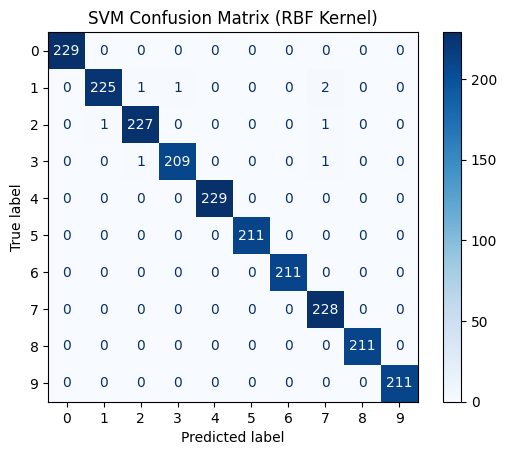

In [ ]:
# 5. Performance Evaluation
# --------------------------
y_pred = best_svm.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                       display_labels=range(10),
                                       cmap='Blues')
plt.title("SVM Confusion Matrix (RBF Kernel)")
plt.show()

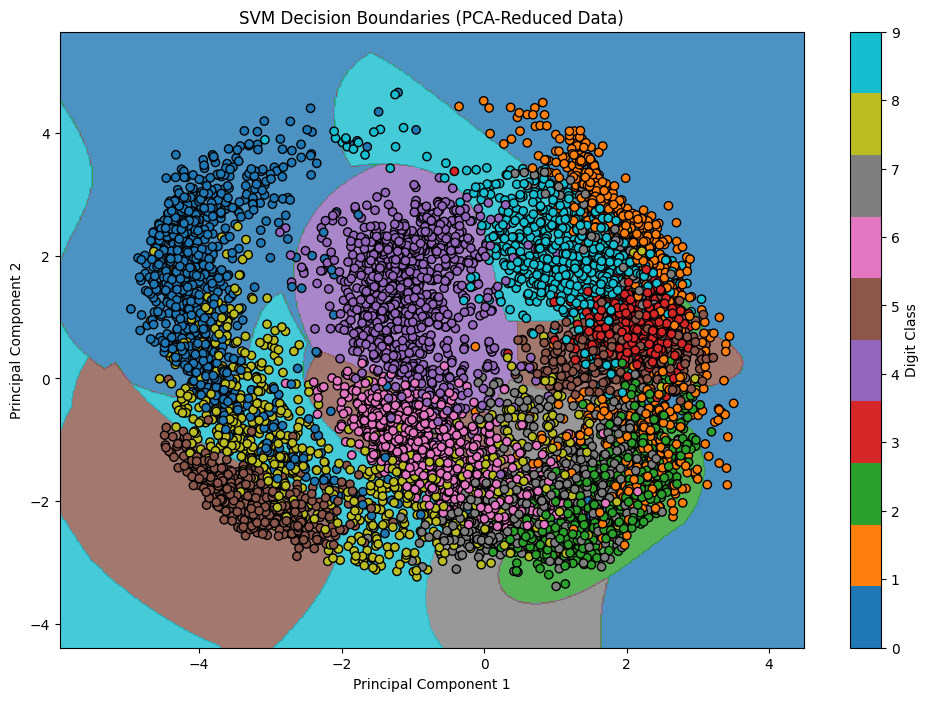

In [ ]:
# 6. Support Vector Visualization (2D Projection)
# --------------------------
from sklearn.decomposition import PCA

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Train SVM on reduced data
svm_vis = SVC(kernel='rbf', C=best_svm.C, gamma=best_svm.gamma)
svm_vis.fit(X_pca, y_train)

# Create mesh grid
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

xx, yy = make_meshgrid(X_pca[:, 0], X_pca[:, 1])

# Plot decision boundaries
Z = svm_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.tab10)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train,
            edgecolors='k', cmap=plt.cm.tab10)
plt.title("SVM Decision Boundaries (PCA-Reduced Data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Digit Class')
plt.show()